## Config

In [20]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from matplotlib.patches import Patch
from datetime import datetime, timedelta
import numpy as np
import os
import math
import time
import sys
sys.path.append('..')

from source.utils import split_run_results

# use colorblind color palette 
plt.style.use('tableau-colorblind10')


In [63]:
'''
    USER INPUT
'''

DO_SAVE = True
#run_names = ['resnet101_pr50_lcm0.0001_batch16', 'resnet101_pr75_lcm0.0001_batch16', 'resnet101_pr85_lcm0.0001_batch16'] # these logs dont have rx ip and port yet 
#run_names = ['resnet18_pr50_lcm0.0001_batch64', 'resnet18_pr75_lcm0.0001_batch64', 'resnet18_pr85_lcm0.0001_batch64'] # these logs dont have rx ip and port yet
#run_names = [ 'filter']
run_names = ['cifar100-resnet101-kernel-np4-pr0.5-lcm1e-04-batch16', 'cifar100-resnet101-kernel-np4-pr0.75-lcm1e-04-batch16']
num_runs = len(run_names)
test_name = run_names[0]
log_name = 'resnet101'
num_nodes = 4

save_dir = os.path.join('./assets', 'figs', test_name)
log_file_path = os.path.join('./logs', test_name)

if DO_SAVE:
    os.makedirs(save_dir, exist_ok=True)

In [14]:
block_event_df, layer_event_df, total_runtime = split_run_results.combine_log_files(log_file_path, log_name, num_nodes)

In [26]:
''' 
    Make block event timeline plot
'''
#block_event_df[block_event_df['node'] == 0][['type', 'timestamp','time','dur', 'type']].head(7)
block_event_df


,timestamp,time,node,layer,layer_name,type,dur,process_dur,bytes_tx,serialize_dur,encode_dur_tx,ip,port,bytes_rx,deserialize_time,end_time
146,2024-10-07 09:52:08.358164600,0.0000,1,0,NaN,receive,1.8354,NaN,NaN,NaN,NaN,NaN,NaN,262280.0,4.0383,1.8354
0,2024-10-07 09:52:08.362000000,3.8354,1,0,NaN,idle,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8354
22,2024-10-07 09:52:08.362163900,3.9993,1,1,conv1,execute,38.8361,5.2279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.8354
145,2024-10-07 09:52:08.363455600,5.2910,2,0,NaN,receive,1.5444,NaN,NaN,NaN,NaN,NaN,NaN,262280.0,4.0385,6.8354
0,2024-10-07 09:52:08.366000000,7.8354,2,0,NaN,idle,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.8354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,2024-10-07 09:52:11.066915000,2708.7504,1,69,NaN,receive,0.0850,NaN,NaN,NaN,NaN,NaN,NaN,1006.0,0.5013,2708.8354
207,2024-10-07 09:52:11.067935000,2709.7704,1,69,NaN,receive,0.0650,NaN,NaN,NaN,NaN,NaN,NaN,1006.0,0.5357,2709.8354
102,2024-10-07 09:52:11.068661700,2710.4971,3,69,NaN,send,0.3383,NaN,1006.0,0.1892,0.0014,127.0.0.1,5001.0,NaN,NaN,2710.8354
208,2024-10-07 09:52:11.069984700,2711.8201,1,69,NaN,receive,0.0153,NaN,NaN,NaN,NaN,NaN,NaN,1006.0,0.4072,2711.8354


## Plots Sandbox

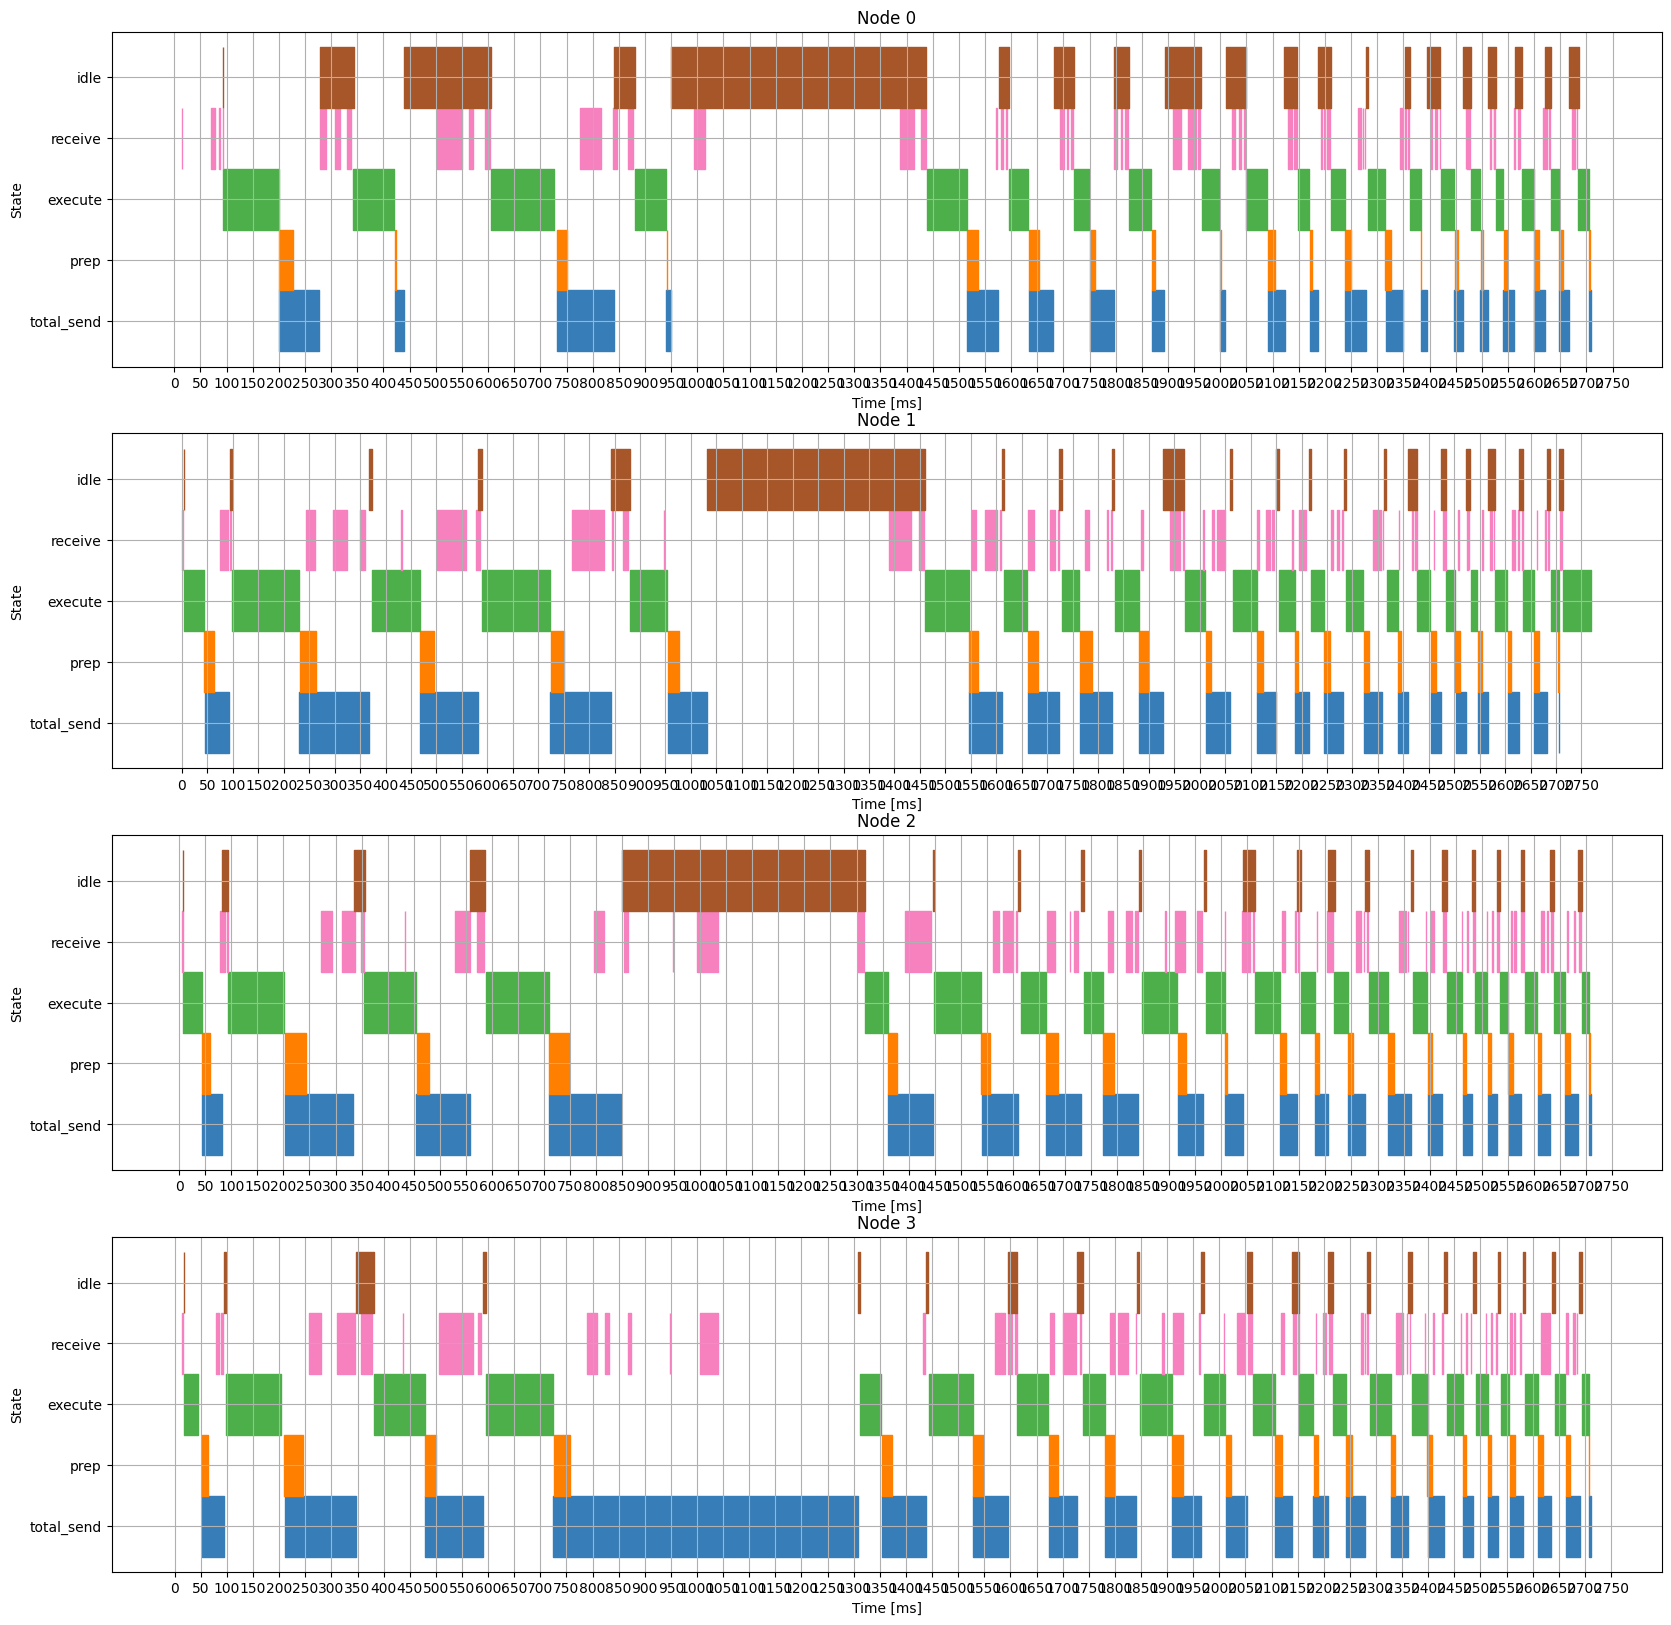

In [5]:
'''
    Plot timeline 
'''

def seq_of_tuples(df, col1, col2):
    return list(zip(df[col1], df[col2]))

# get layers that wait on inputs 
begin_block_layers = np.unique(block_event_df['layer'].to_numpy())

yheigth = 1
ystep = 1

comms_width = yheigth/num_nodes

fig, axs = plt.subplots(num_nodes, 1)
fig.set_size_inches(20,20)

# TODO: do for each node
inode = 0
state_types = ['total_send', 'prep','execute', 'receive', 'idle']
CB_color_cycle = ['#377eb8', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
num_states = len(state_types)

for inode in range(num_nodes):
    axs[inode].grid()
    for istate in range(num_states):

        state_type = state_types[istate]

        # format data and plot
        bars = seq_of_tuples(block_event_df.loc[(block_event_df['node'] == inode) & (block_event_df['type'] == state_type)], 'time', 'dur')
        axs[inode].broken_barh(bars, (ystep*istate - yheigth/2,yheigth), color=CB_color_cycle[istate])


    title_str = f'Node {inode}'
    axs[inode].set_title(title_str)
    axs[inode].set_xlabel('Time [ms]')
    axs[inode].set_ylabel('State')
    axs[inode].set_yticks(ticks=range(0, num_states*ystep, ystep), labels=state_types)

    xlim_range = []#[0, 200] #[700, 800]
    step_size = 50

    if [] == xlim_range:
        axs[inode].set_xticks(range(0, math.ceil(max(total_runtime)*1e3), step_size))
    else:
        axs[inode].set_xlim(xlim_range)
        axs[inode].set_xticks(range(xlim_range[0], xlim_range[1], step_size))
    
    #plt.legend(state_types)
    #plt.xlim(0,max(total_runtime)*1.1)

#fig.show()
#plt.ion()
#_ = plt.show()
    

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'block_execution_time.jpg'))




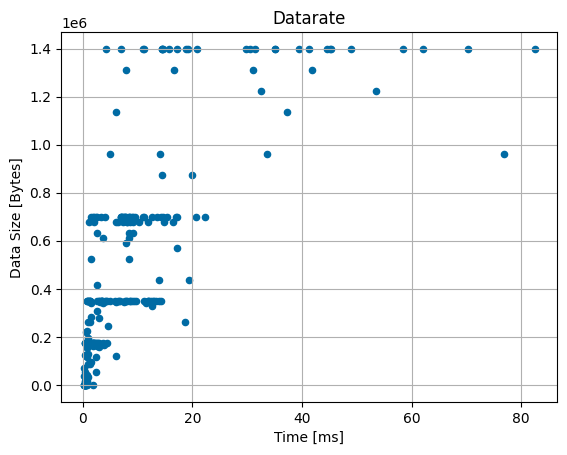

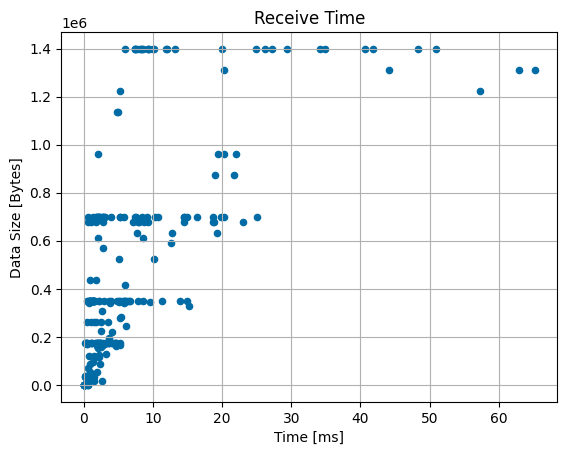

In [6]:
'''
    Make scatter plots for TX and RX
'''

ax_send = block_event_df[block_event_df['type'] == 'send'].plot.scatter(x='dur', y='bytes_tx')
ax_send.set_xlabel('Time [ms]')
ax_send.set_ylabel('Data Size [Bytes]')
ax_send.set_title('Datarate')
ax_send.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_send.jpg'))

# TODO: fix the measurment of time in debugger logging
ax_receive = block_event_df[block_event_df['type'] == 'receive'].plot.scatter(x='dur', y='bytes_rx')
ax_receive.set_xlabel('Time [ms]')
ax_receive.set_ylabel('Data Size [Bytes]')
ax_receive.set_title('Receive Time')
ax_receive.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_receive.jpg'))




In [7]:
'''
    Breakdown of total time spent in different states
'''

def sum_dur(df, type, node):
    mask = (df['type'] == type) & (df['node'] == node)
    return sum(df['dur'].loc[mask])

for i in range(num_nodes):
    total_idle_time = sum_dur(block_event_df, 'idle', i)
    total_process_time = sum_dur(block_event_df, 'process_dur', i)
    total_exec_time = sum_dur(block_event_df, 'execute', i)
    total_tx_time = sum_dur(block_event_df, 'send', i)
    total_prep_time = sum_dur(block_event_df, 'prep', i)
    total_rx_time = sum_dur(block_event_df, 'receive', i)
    timed_total_time = total_runtime[i]

    percent_idle = total_idle_time/total_runtime[i]*100/1e3
    percent_process_time = total_process_time/total_runtime[i]*100/1e3
    percent_exec_time = total_exec_time/total_runtime[i]*100/1e3
    percent_tx_time = total_tx_time/total_idle_time*100/1e3 # overlap in idle time and tx time
    percent_prep_time = total_prep_time/total_runtime[i]*100/1e3
    percent_rx_time = total_rx_time/total_idle_time*100
    percent_total_time =timed_total_time/total_runtime[i]*100/1e3

    data = {
            'States': ["IDLE", "CHECK IN (IDLE)", "TX (IDLE)", "RX (IDLE)", "EXECUTING", "PREP", "Total"], 
            'Time [ms]':[total_idle_time, total_process_time, total_tx_time, total_rx_time, total_exec_time, total_prep_time, timed_total_time],
            'Percent [%]':[percent_idle, percent_process_time, percent_tx_time, percent_rx_time, percent_exec_time, percent_prep_time, percent_total_time], 
            }
    df = pd.DataFrame(data)
    print(f'Node {i}')
    print(f'Run time {total_runtime[i]}s')
    print(df)
    print()


Node 0
Run time 2.6156253999797627s
            States    Time [ms]  Percent [%]
0             IDLE  1115.275100    42.638946
1  CHECK IN (IDLE)     0.000000     0.000000
2        TX (IDLE)   292.299000     0.026209
3        RX (IDLE)   360.037500    32.282394
4        EXECUTING   836.872500    31.995121
5             PREP   178.808500     6.836166
6            Total     2.615625     0.100000

Node 1
Run time 2.7648863999638706s
            States    Time [ms]  Percent [%]
0             IDLE   629.667700    22.773728
1  CHECK IN (IDLE)     0.000000     0.000000
2        TX (IDLE)   610.050300     0.096884
3        RX (IDLE)   463.053500    73.539345
4        EXECUTING  1058.166000    38.271590
5             PREP   307.221300    11.111534
6            Total     2.764886     0.100000

Node 2
Run time 2.702396399981808s
            States   Time [ms]  Percent [%]
0             IDLE  645.515400    23.886777
1  CHECK IN (IDLE)    0.000000     0.000000
2        TX (IDLE)  658.126200     0.10

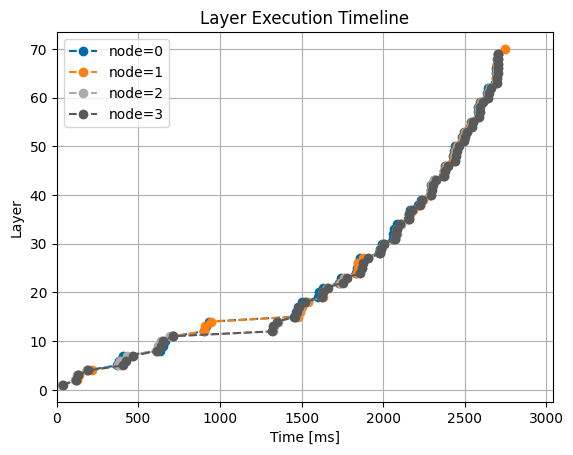

In [8]:
'''
    Look at layer execution times
'''

plt.figure()
plt.grid()
legend_strs = []
for i in range(4):
    plt.plot(layer_event_df[layer_event_df['node'] == i]['time'] ,layer_event_df[layer_event_df['node'] == i]['layer'], '--o')
    legend_strs += [f'node={i}']
plt.title('Layer Execution Timeline')
plt.xlabel('Time [ms]')
plt.ylabel('Layer')
plt.legend(legend_strs)
#_ = plt.xticks(np.arange(0, 10, step=1))
plt.xlim(0,max(total_runtime)*1.1*1e3)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'layer_execution_time.jpg'))



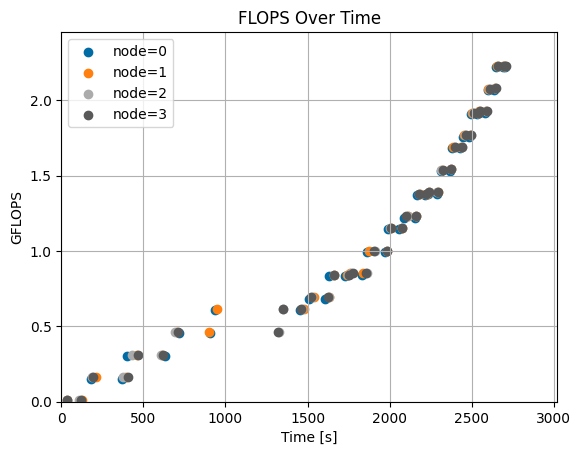

In [9]:

plt.figure()
plt.grid()
legend_strs = []
max_cum_bytes = 0
for i in range(num_nodes):

    tmp_merged_layer_df = layer_event_df[layer_event_df['node'] == i]
    nan_mask = tmp_merged_layer_df['FLOPS'].isna() == 0
    cum_bytes = np.cumsum(tmp_merged_layer_df[nan_mask]['FLOPS'].to_numpy())
    plt.scatter(tmp_merged_layer_df[nan_mask]['time'] ,cum_bytes/1e9)

    if max_cum_bytes < cum_bytes[-1]:
        max_cum_bytes = cum_bytes[-1]/1e9

    legend_strs += [f'node={i}']
plt.title('FLOPS Over Time')
plt.xlabel('Time [s]')
plt.ylabel('GFLOPS')
_ = plt.legend(legend_strs)
plt.xlim(0, max(layer_event_df['time'])*1.1)
plt.ylim(0,max_cum_bytes*1.1)
#_ = plt.xticks(np.arange(0, 250, step=20))

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'FLOPS.jpg'))


In [10]:
layer_event_df['FLOPS']

3     9437184.0
2     9437184.0
2     9437184.0
1      524288.0
1      524288.0
        ...    
65      40800.0
67          NaN
68          NaN
65      40800.0
0           NaN
Name: FLOPS, Length: 276, dtype: float64

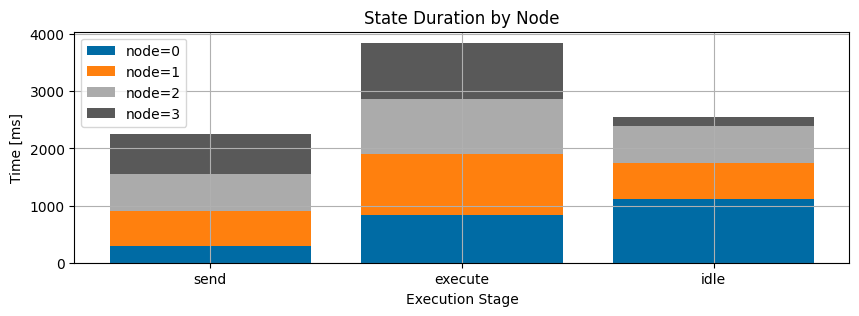

In [11]:
'''
    WIP Compare durations from different states 

'''

stages = ["send", "execute", "idle"]
num_stages = len(stages)
legend_strs = []

plt.figure(figsize=(10,3))
plt.grid()
bot = np.zeros(num_stages)
for inode in range(4):

    stages_array = np.array([])
    for a_stage in stages:
        stages_array = np.append(stages_array, block_event_df[(block_event_df['node'] == inode) & (block_event_df['type'] == a_stage) ]['dur'].sum(axis=0))
    plt.bar(stages, stages_array, bottom=bot)
    bot += stages_array

    legend_strs += [f'node={inode}']

plt.title(f'State Duration by Node')
plt.xlabel('Execution Stage')
plt.ylabel('Time [ms]')
plt.legend(legend_strs)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
#plt.ylim(0, 50)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, f'state_dur_compare_node-{test_name}.jpg'))

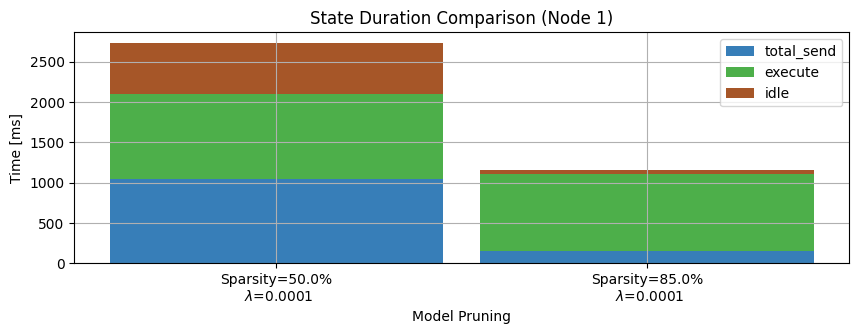

In [13]:
'''
    WIP Compare runtimes from different runs 

    # TODO: put bars next to one another 

'''

 
CB_color_cycle_short = ['#377eb8', '#4daf4a', '#a65628']
stages = ['total_send','execute', 'idle']
num_stages = len(stages)

# ticks 
legend_strs = []

width = 0.9

# make plot 
plt.figure(figsize=(10,3))
plt.grid()

# iterators
inode = 1
data_frames = []
model_names= []
bottom = np.zeros(num_runs)

# get df for each run 
for irun in range(num_runs):
    run_name = run_names[irun]
    data_frames.append( split_run_results.combine_log_files(os.path.join('logs', run_name), log_name, num_nodes)[0] )

    model_params = run_names[irun].split('-')
    sparsity_percent = 100*float(model_params[4][2:])
    lcm = float(model_params[5][3:] + '-' + model_params[6])
    model_names.append(f'Sparsity={sparsity_percent}%\n $\lambda$={lcm}')

# plot 1 stage at a time 
istage = 0
for a_stage in stages:

    # fill array with value for each run 
    stages_array = np.array([])
    for irun in range(num_runs):
        master_tmp = data_frames[irun] 
        stages_array = np.append(stages_array, master_tmp[(master_tmp['type'] == a_stage) & (master_tmp['node']==inode)]['dur'].sum(axis=0))

    # plot 
    plt.bar(model_names, stages_array, width=width, align='center', bottom=bottom, color=CB_color_cycle_short[istage])

    # increase counters
    bottom += stages_array
    istage += 1
    irun += 1

#ax = plt.gca()
#ax.set_yscale('log')

# labels
plt.title(f'State Duration Comparison (Node {inode})')
plt.xlabel('Model Pruning')
plt.ylabel('Time [ms]')
plt.legend(stages)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
#plt.ylim(0, 50)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'state_dur_compare_stacked.jpg'))

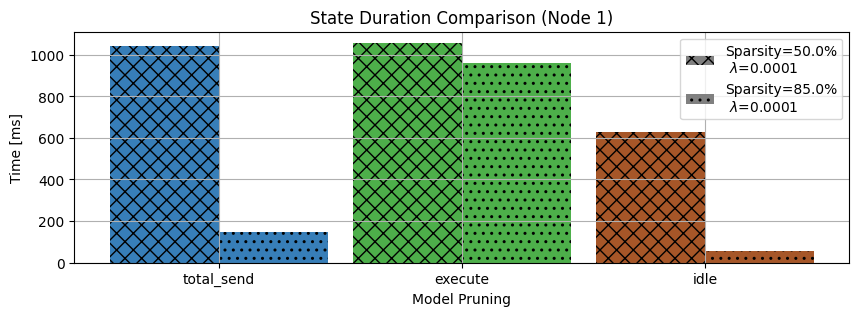

In [12]:
'''
    WIP Compare runtimes from different runs 

    # TODO: put bars next to one another 

'''
 
CB_color_cycle_short = ['#377eb8', '#4daf4a', '#a65628']
hatch_list = ["xx", "..", "\\\\", "**"]
stages = ['total_send','execute', 'idle']
num_stages = len(stages)

# ticks 
width = 0.9
stage_values = np.arange(num_stages)*num_runs
run_values = np.arange(num_runs)*width
legend_strs = []

# make plot 
plt.figure(figsize=(10,3))
plt.grid()

# iterators
inode = 1
data_frames = []
model_names= []
bottom = np.zeros(num_runs)

# get df for each run 
for irun in range(num_runs):
    run_name = run_names[irun]
    data_frames.append( split_run_results.combine_log_files(os.path.join('logs', run_name), log_name, num_nodes)[0] )

    model_params = run_names[irun].split('-')
    sparsity_percent = 100*float(model_params[4][2:])
    lcm = float(model_params[5][3:] + '-' + model_params[6])
    model_names.append(f'Sparsity={sparsity_percent}%\n $\lambda$={lcm}')

    # make dummy bar for legend 
    plt.bar(0, 0, color="gray",  hatch= hatch_list[irun])

# plot 1 stage at a time 
istage = 0
for a_stage in stages:

    # fill array with value for each run 
    stages_array = np.array([])
    for irun in range(num_runs):
        master_tmp = data_frames[irun] 
        stage_time = master_tmp[(master_tmp['type'] == a_stage) & (master_tmp['node']==inode)]['dur'].sum(axis=0)

        # plot 
        plt.bar(stage_values[istage] + run_values[irun] - width/num_runs,
                    stage_time,
                    width=width,
                    align='center', 
                    color=CB_color_cycle_short[istage], 
                    hatch= hatch_list[irun])

    # increase counters
    istage += 1
    irun += 1

# labels
plt.xticks(stage_values, stages)
plt.title(f'State Duration Comparison (Node {inode})')
plt.xlabel('Model Pruning')
plt.ylabel('Time [ms]')
plt.legend(model_names)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
#plt.ylim(0, 50)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'state_dur_compare.jpg'))

## Animations

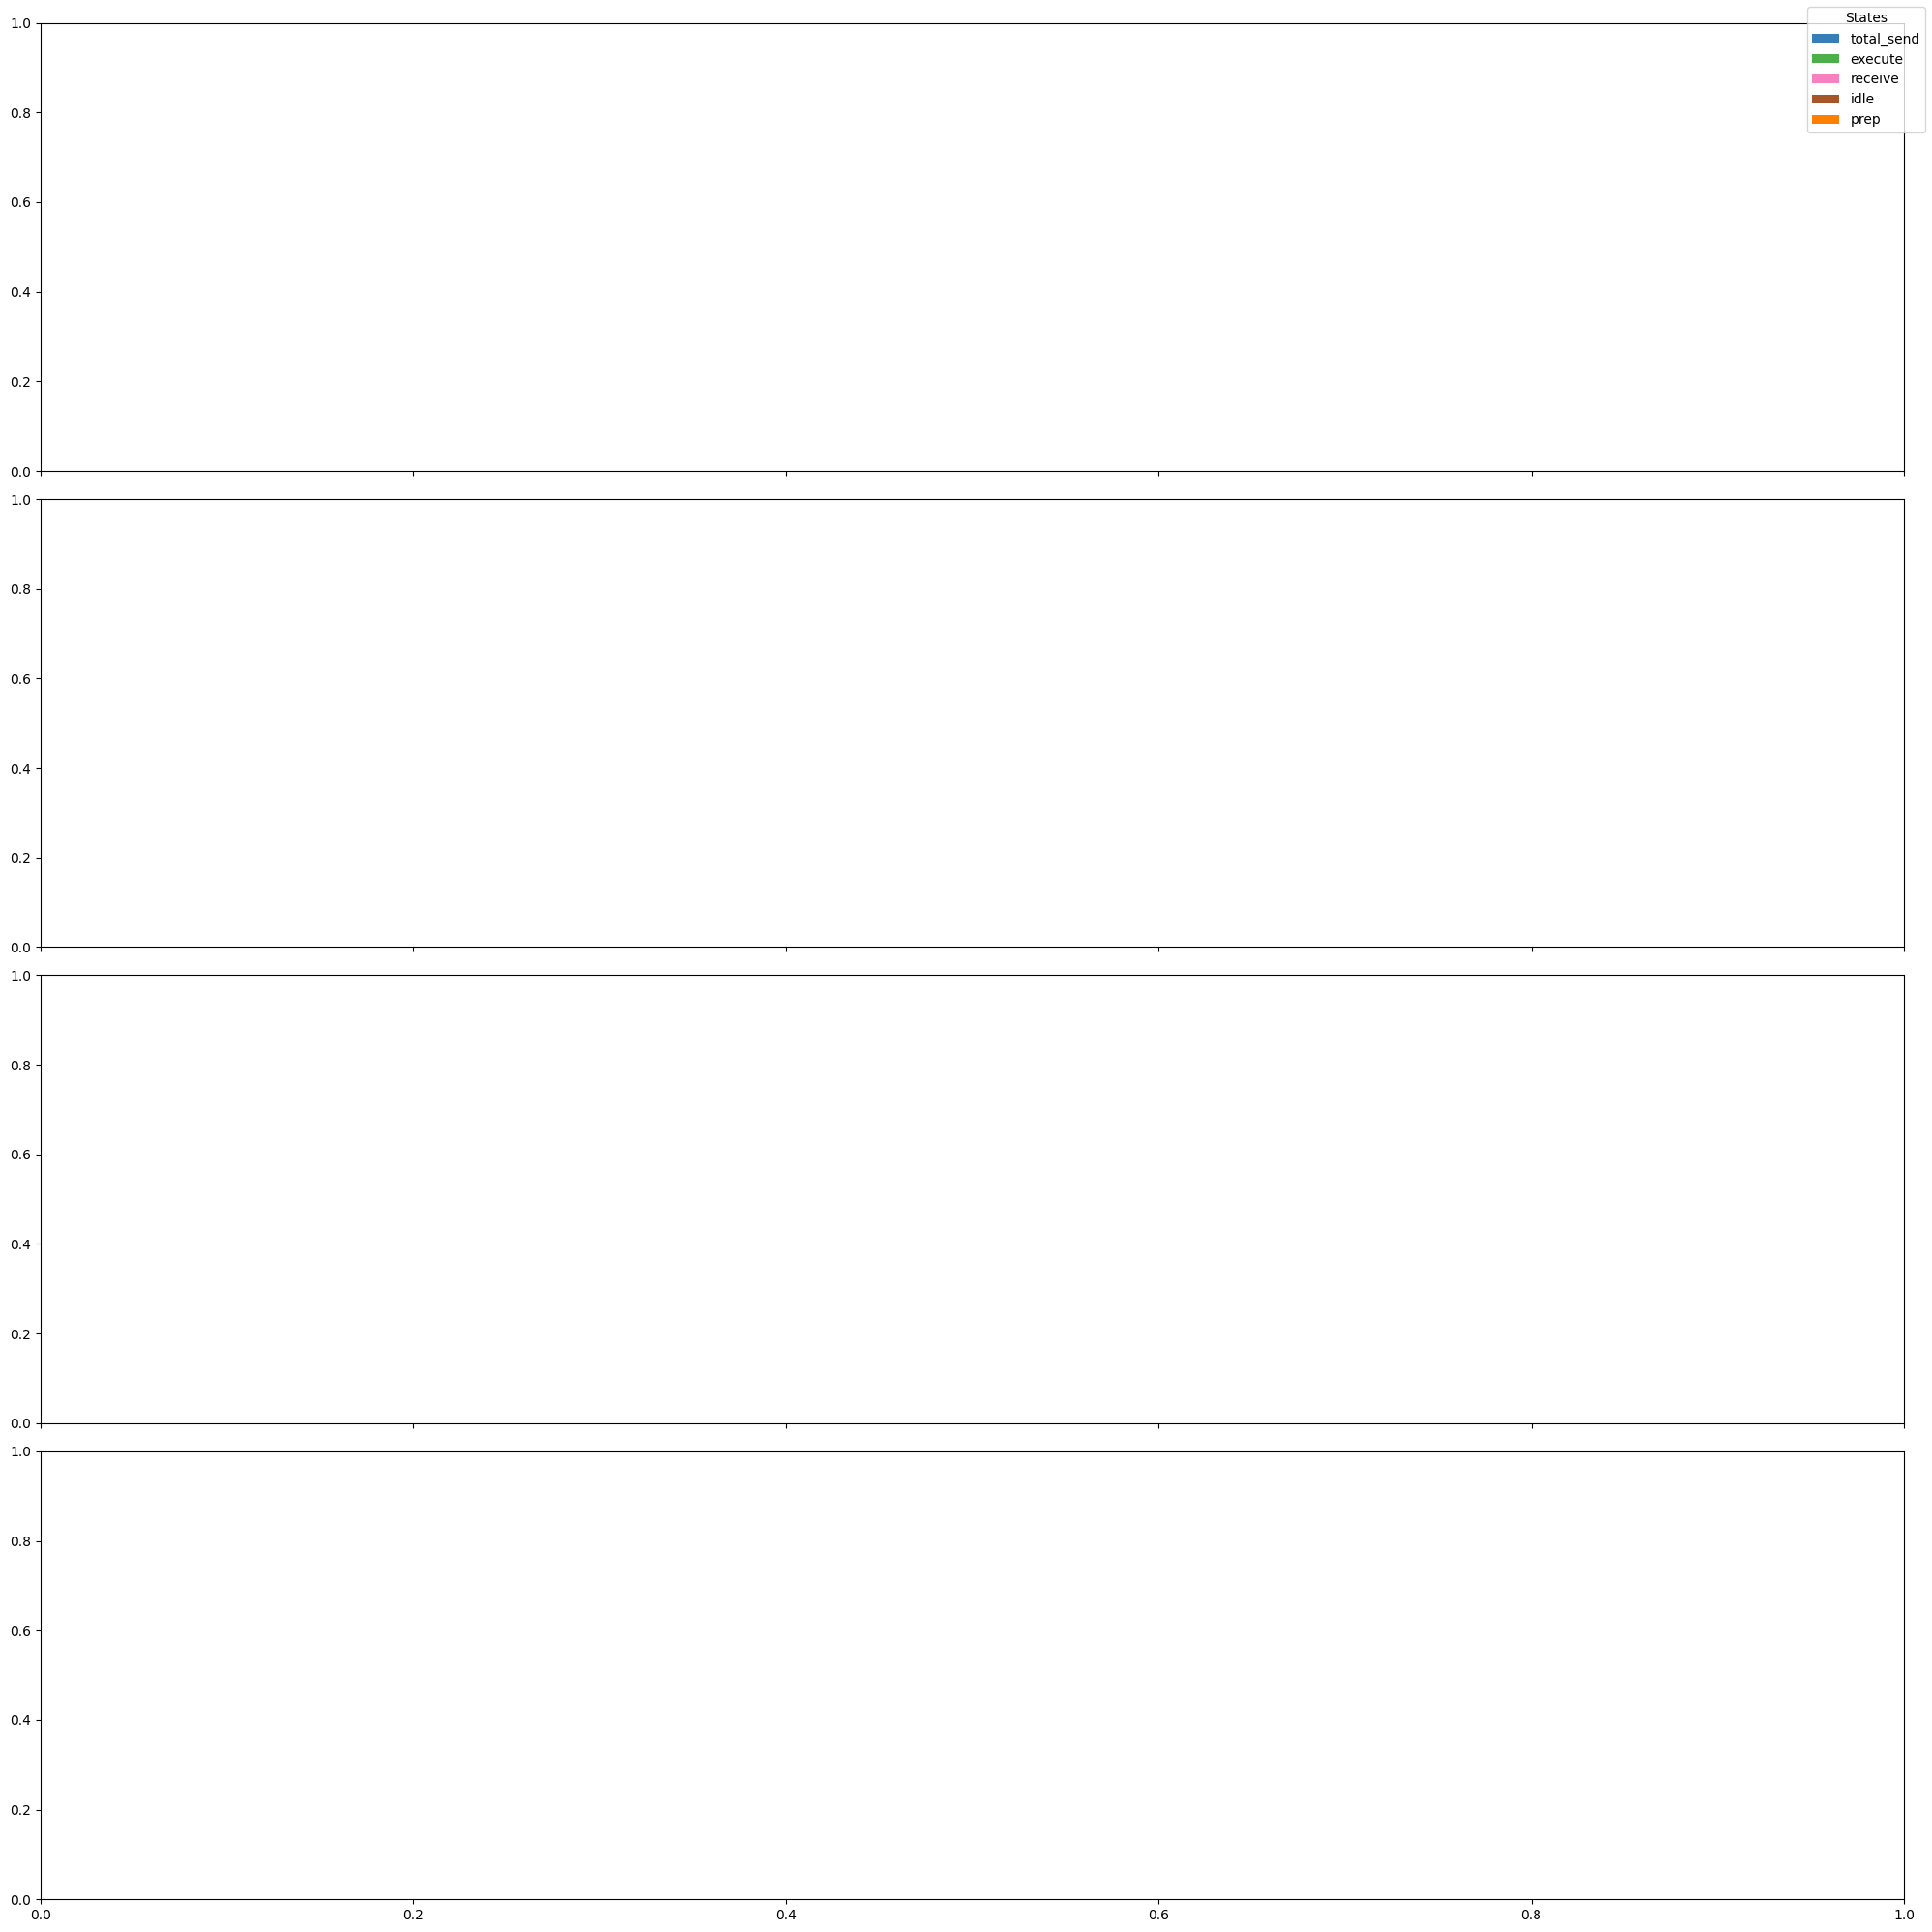

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from matplotlib.patches import Patch  # For creating legend entries

def seq_of_tuples(df, col1, col2):
    return list(zip(df[col1], df[col2]))

# Define parameters
yheight = 1
ystep = 1

# Replace 'num_nodes' with the actual number of nodes in your data
num_nodes = block_event_df['node'].nunique()
comms_width = yheight / num_nodes

state_types = ['total_send', 'execute', 'receive', 'idle']
state_type_positions = {state: idx for idx, state in enumerate(state_types)}
state_colors = {
    'total_send': '#377eb8',
    'execute': '#4daf4a',
    'receive': '#f781bf',
    'idle': '#a65628',
    'prep': '#ff7f00'  # Color for 'prep' overlay
}

num_states = len(state_types)
max_time = (block_event_df['time'] + block_event_df['dur']).max()

# Preprocess data outside the animate function
plot_data = {}  # Dictionary to store data for each node and state
for inode in range(num_nodes):
    plot_data[inode] = {}
    node_df = block_event_df[block_event_df['node'] == inode]
    for state in state_types + ['prep']:
        df_state = node_df[node_df['type'] == state]
        bars = seq_of_tuples(df_state, 'time', 'dur')
        plot_data[inode][state] = bars

fig, axs = plt.subplots(num_nodes, 1, figsize=(20, 20), sharex=True)

# Create legend entries
legend_patches = []
for state in state_types:
    patch = Patch(facecolor=state_colors[state], label=state)
    legend_patches.append(patch)

# Add legend entry for 'prep' overlay
prep_patch = Patch(facecolor=state_colors['prep'], label='prep')
legend_patches.append(prep_patch)

# Add the legend to the figure (only once)
fig.legend(handles=legend_patches, loc='upper right', title='States')

def animate(frame_num):
    current_time = frame_num * 50  # Update every 50 ms
    for inode in range(num_nodes):
        ax = axs[inode]
        ax.clear()  # Clear the axis
        
        # Set labels and limits
        ax.set_ylabel(f'Node {inode}')
        ax.set_yticks([])
        ax.set_xlim(0, max_time)
        ax.set_ylim(-1, num_states * ystep)
        ax.grid(False)
        
        # Plot the bars for each state
        for istate, state in enumerate(state_types):
            bars = plot_data[inode][state]
            for bar in bars:
                start_time, duration = bar
                end_time = start_time + duration
                if end_time < 0 or start_time > current_time:
                    continue
                plot_start_time = max(start_time, 0)
                plot_end_time = min(end_time, current_time)
                plot_dur = plot_end_time - plot_start_time
                if plot_dur <= 0:
                    continue
                rect = patches.Rectangle(
                    (plot_start_time, ystep * istate),
                    plot_dur,
                    yheight,
                    facecolor=state_colors[state],
                    edgecolor='none'
                )
                ax.add_patch(rect)
        
        # Overlay 'prep' on 'total_send'
        istate = state_type_positions['total_send']
        bars_prep = plot_data[inode]['prep']
        for bar in bars_prep:
            start_time, duration = bar
            end_time = start_time + duration
            if end_time < 0 or start_time > current_time:
                continue
            plot_start_time = max(start_time, 0)
            plot_end_time = min(end_time, current_time)
            plot_dur = plot_end_time - plot_start_time
            if plot_dur <= 0:
                continue
            rect = patches.Rectangle(
                (plot_start_time, ystep * istate),
                plot_dur,
                yheight,
                facecolor=state_colors['prep'],
                edgecolor='none'
            )
            ax.add_patch(rect)
        
        # Optional: Add node title within the animate function if titles need to be updated
        ax.set_title(f'Node {inode}')

num_frames = int(max_time / 50) + 1

ani = FuncAnimation(
    fig,
    animate,
    frames=num_frames,
    interval=50,
    repeat=False
)

plt.tight_layout()
plt.show()

# Save the animation if needed
if DO_SAVE:
    # Since FFmpeg is unavailable, save as GIF using Pillow writer
    ani.save(os.path.join(save_dir, 'block_execution_time_animation.gif'), writer='pillow', fps=20)


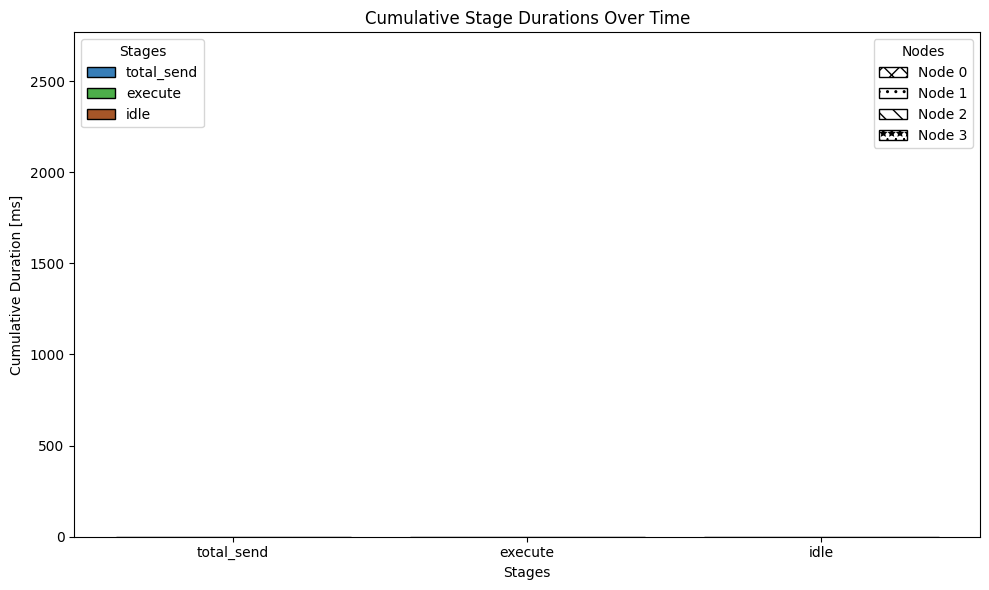

In [18]:
# Define stages and nodes
stages = ['total_send', 'execute', 'idle']
num_stages = len(stages)
num_nodes = 4  # Nodes 0 to 3

# Define colors and hatches
stage_colors = ['#377eb8', '#4daf4a', '#a65628']  # Colors for the stages
hatch_list = ["xx", "..", "\\\\", "**"]  # Hatches for the nodes
data_frame = block_event_df
# Define time steps for the animation
dt = 50  # Time step in ms
data_frame['end_time'] = data_frame['time'] + data_frame['dur']
max_time = data_frame['end_time'].max()
time_steps = np.arange(0, max_time + dt, dt)
num_time_steps = len(time_steps)

# Initialize cumulative_durations array
# Shape: (num_nodes, num_stages, num_time_steps)
cumulative_durations = np.zeros((num_nodes, num_stages, num_time_steps))

# Compute cumulative durations for each node, stage, and time step
for node in range(num_nodes):
    for stage_idx, stage in enumerate(stages):
        events = data_frame[(data_frame['node'] == node) & (data_frame['type'] == stage)]
        event_start_times = events['time'].values  # Shape: (N,)
        event_durs = events['dur'].values  # Shape: (N,)
        if len(event_start_times) == 0:
            continue
        # Compute contributions over time steps
        contributions = np.clip(
            time_steps[np.newaxis, :] - event_start_times[:, np.newaxis],
            0,
            event_durs[:, np.newaxis]
        )
        cumulative_durations[node, stage_idx, :] = contributions.sum(axis=0)

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

x_positions = np.arange(num_stages)  # Positions for stages
bar_width = 0.8 / num_nodes  # Bar width per node

# Initialize bars and store them in a dictionary
bars = {}  # bars[node][stage_idx] = bar

for node in range(num_nodes):
    x = x_positions + (node - (num_nodes - 1)/2) * bar_width
    node_bars = []
    for stage_idx, stage in enumerate(stages):
        bar = ax.bar(
            x[stage_idx],
            0,  # Initial height
            width=bar_width,
            color=stage_colors[stage_idx],
            hatch=hatch_list[node],
            edgecolor='black'
        )
        node_bars.append(bar[0])  # bar() returns a container; get the Bar object
    bars[node] = node_bars

# Set labels and title
ax.set_xticks(x_positions)
ax.set_xticklabels(stages)
ax.set_xlabel('Stages')
ax.set_ylabel('Cumulative Duration [ms]')
ax.set_ylim([0,max_time])
ax.set_title('Cumulative Stage Durations Over Time')

# Create custom legend entries
# Legend for nodes (hatches)
node_patches = [
    Patch(facecolor='white', edgecolor='black', hatch=hatch_list[node], label=f'Node {node}')
    for node in range(num_nodes)
]

# Legend for stages (colors)
stage_patches = [
    Patch(facecolor=stage_colors[stage_idx], edgecolor='black', label=stage)
    for stage_idx, stage in enumerate(stages)
]

# Add legends to the plot
legend1 = ax.legend(handles=stage_patches, title='Stages', loc='upper left')
legend2 = ax.legend(handles=node_patches, title='Nodes', loc='upper right')
ax.add_artist(legend1)  # Add the first legend back to the axes

def animate(frame):
    t = time_steps[frame]
    for node in range(num_nodes):
        for stage_idx in range(num_stages):
            height = cumulative_durations[node, stage_idx, frame]
            bar = bars[node][stage_idx]
            bar.set_height(height)
    ax.set_title(f'Cumulative Stage Durations at Time {t:.0f} ms')
    return [bar for node_bars in bars.values() for bar in node_bars]

# Create the animation
ani = FuncAnimation(
    fig,
    animate,
    frames=num_time_steps,
    interval=100,  # Adjust the interval as needed
    blit=False,
    repeat=False
)

plt.tight_layout()
plt.show()

# Save the animation if needed
if DO_SAVE:
    # Ensure you have 'pillow' installed (`pip install pillow`)
    ani.save(os.path.join(save_dir, 'state_dur_compare_animation.gif'), writer='pillow', fps=10)


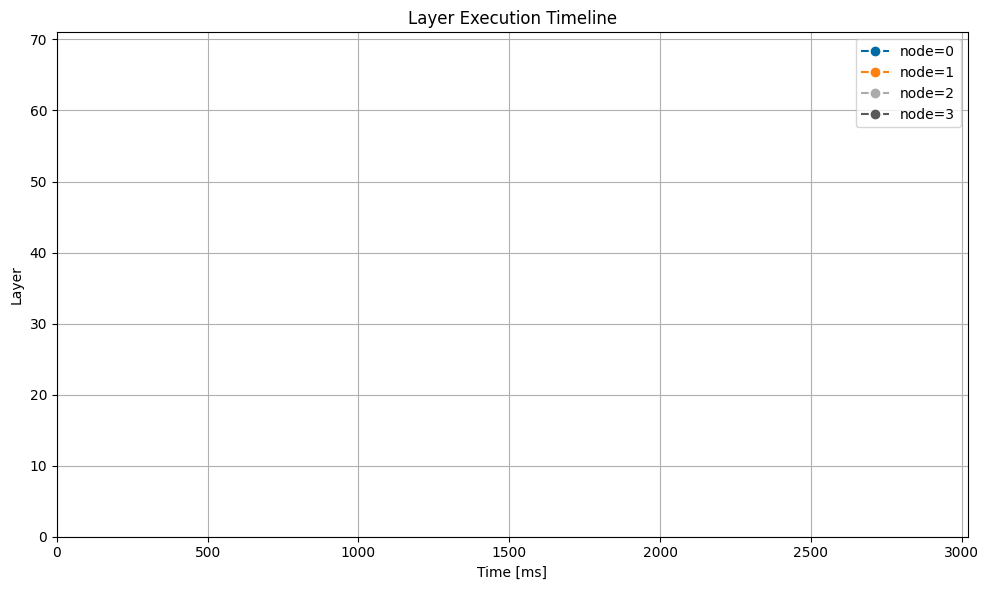

In [22]:
# Parameters
num_nodes = 4  # Number of nodes (0 to 3)
dt = 50        # Time step in milliseconds
max_time = layer_event_df['time'].max()
time_steps = np.arange(0, max_time + dt, dt)

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.set_title('Layer Execution Timeline')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Layer')
ax.set_xlim(0, max_time * 1.1)
ax.set_ylim(layer_event_df['layer'].min() - 1, layer_event_df['layer'].max() + 1)

# Initialize lines for each node
lines = []
legend_strs = []
for i in range(num_nodes):
    line, = ax.plot([], [], '--o', label=f'node={i}')
    lines.append(line)
    legend_strs.append(f'node={i}')

ax.legend()

# Preprocess data for each node
node_data = {}
for i in range(num_nodes):
    df_node = layer_event_df[layer_event_df['node'] == i].sort_values('time')
    node_data[i] = df_node

def init():
    # Initialize empty data for each line
    for line in lines:
        line.set_data([], [])
    return lines

def animate(frame):
    current_time = time_steps[frame]
    for i, line in enumerate(lines):
        df_node = node_data[i]
        # Filter data up to the current time
        df_node_current = df_node[df_node['time'] <= current_time]
        x_data = df_node_current['time'].values
        y_data = df_node_current['layer'].values
        line.set_data(x_data, y_data)
    ax.set_xlim(0, max_time * 1.1)
    ax.set_ylim(layer_event_df['layer'].min() - 1, layer_event_df['layer'].max() + 1)
    ax.set_title(f'Layer Execution Timeline (Time: {current_time:.0f} ms)')
    return lines

# Create the animation
num_frames = len(time_steps)
ani = FuncAnimation(
    fig,
    animate,
    frames=num_frames,
    init_func=init,
    interval=100,  # Adjust interval as needed
    blit=False,
    repeat=False
)

plt.tight_layout()
plt.show()

# Save the animation if needed
if DO_SAVE:
    # Ensure you have 'pillow' installed (`pip install pillow`)
    ani.save(os.path.join(save_dir, 'layer_execution_time_animation.gif'), writer='pillow', fps=10)


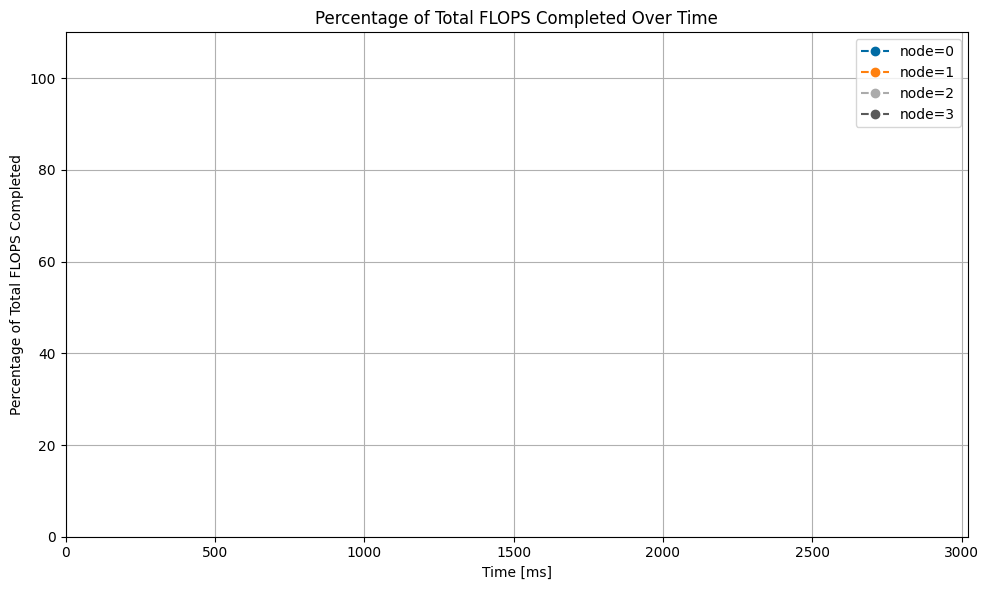

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd

# Assuming 'layer_event_df' is your DataFrame with columns: 'time', 'FLOPS', 'node'
# Also assuming 'num_nodes' is defined

# Parameters
num_nodes = layer_event_df['node'].nunique()
dt = 50  # Time step in milliseconds
max_time = layer_event_df['time'].max()
time_steps = np.arange(0, max_time + dt, dt)

# Preprocess data per node
node_data = {}
total_flops = {}

for i in range(num_nodes):
    df_node = layer_event_df[layer_event_df['node'] == i].sort_values('time')
    # Remove NaNs in 'FLOPS'
    df_node = df_node[df_node['FLOPS'].notna()].reset_index(drop=True)
    node_data[i] = df_node
    # Compute total FLOPS per node
    total_flops[i] = df_node['FLOPS'].sum()

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.set_title('Percentage of Total FLOPS Completed Over Time')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Percentage of Total FLOPS Completed')
ax.set_xlim(0, max_time * 1.1)
ax.set_ylim(0, 110)  # Percentage from 0% to 100%

# Initialize lines for each node
lines = []
for i in range(num_nodes):
    line, = ax.plot([], [], '--o', label=f'node={i}')
    lines.append(line)

ax.legend()

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(frame):
    current_time = time_steps[frame]
    for i, line in enumerate(lines):
        df_node = node_data[i]
        # Filter data up to the current time
        df_node_current = df_node[df_node['time'] <= current_time]
        if df_node_current.empty:
            x_data = []
            y_data = []
        else:
            cum_flops = np.cumsum(df_node_current['FLOPS'].values)
            # Calculate percentage of total FLOPS completed
            percentage = (cum_flops / total_flops[i]) * 100
            x_data = df_node_current['time'].values
            y_data = percentage
        line.set_data(x_data, y_data)
    ax.set_title(f'Percentage of Total FLOPS Completed (Time: {current_time:.0f} ms)')
    return lines

num_frames = len(time_steps)
ani = FuncAnimation(
    fig,
    animate,
    frames=num_frames,
    init_func=init,
    interval=100,  # Adjust interval as needed
    blit=False,
    repeat=False
)

plt.tight_layout()
plt.show()

# Save the animation if needed
if DO_SAVE:
    # Ensure you have 'pillow' installed (`pip install pillow`)
    ani.save(os.path.join(save_dir, 'FLOPS_percentage_animation.gif'), writer='pillow', fps=10)


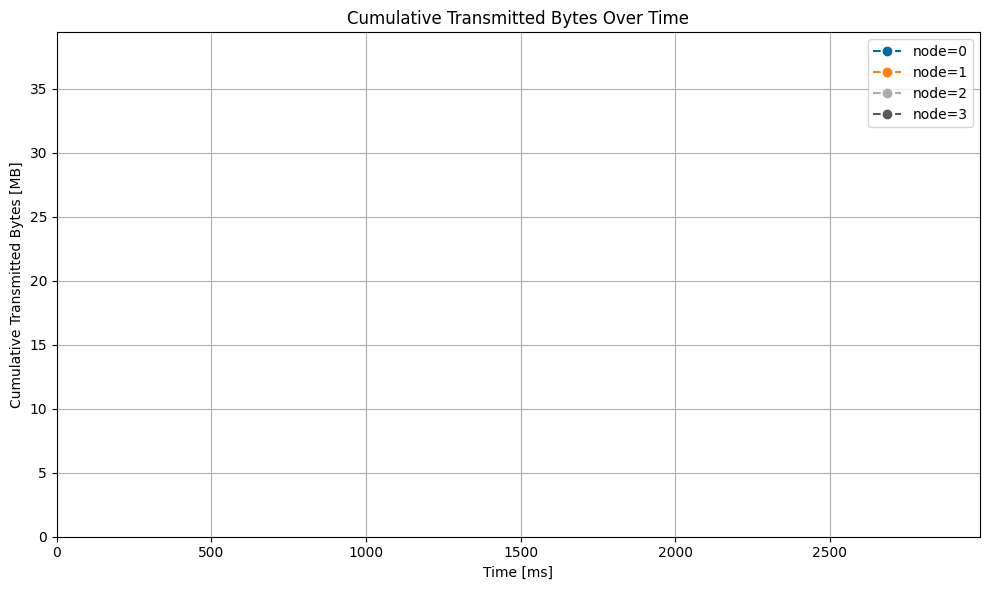

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd

# Assuming 'block_event_df' is your DataFrame with columns: 'time', 'bytes_tx', 'node', 'type'
# Also assuming 'num_nodes' is defined

# Parameters
num_nodes = block_event_df['node'].nunique()
dt = 50  # Time step in milliseconds
max_time = block_event_df['time'].max()
time_steps = np.arange(0, max_time + dt, dt)

# Preprocess data per node
node_data = {}
max_cum_bytes = 0  # To keep track of the maximum cumulative bytes across all nodes

for i in range(num_nodes):
    # Filter data for the node and where 'type' is 'send' and 'bytes_tx' is not null
    df_node = block_event_df[(block_event_df['node'] == i) & 
                             (block_event_df['type'] == 'send') & 
                             (block_event_df['bytes_tx'].notna())].sort_values('time')
    # Reset index after filtering
    df_node = df_node.reset_index(drop=True)
    node_data[i] = df_node
    # Compute cumulative sum of 'bytes_tx' for the node
    cum_bytes = np.cumsum(df_node['bytes_tx'].values)
    if len(cum_bytes) > 0:
        max_cum_bytes = max(max_cum_bytes, cum_bytes[-1])

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.set_title('Cumulative Transmitted Bytes Over Time')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Cumulative Transmitted Bytes [MB]')
ax.set_xlim(0, max_time * 1.1)
ax.set_ylim(0, max_cum_bytes / 1e6 * 1.1)  # Convert bytes to megabytes (MB)

# Initialize lines for each node
lines = []
for i in range(num_nodes):
    line, = ax.plot([], [], '--o', label=f'node={i}')
    lines.append(line)

ax.legend()

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(frame):
    current_time = time_steps[frame]
    for i, line in enumerate(lines):
        df_node = node_data[i]
        # Filter data up to the current time
        df_node_current = df_node[df_node['time'] <= current_time]
        if df_node_current.empty:
            x_data = []
            y_data = []
        else:
            cum_bytes = np.cumsum(df_node_current['bytes_tx'].values)
            x_data = df_node_current['time'].values
            y_data = cum_bytes / 1e6  # Convert bytes to megabytes (MB)
        line.set_data(x_data, y_data)
    ax.set_title(f'Cumulative Transmitted Bytes Over Time (Time: {current_time:.0f} ms)')
    return lines

num_frames = len(time_steps)
ani = FuncAnimation(
    fig,
    animate,
    frames=num_frames,
    init_func=init,
    interval=100,  # Adjust interval as needed
    blit=False,
    repeat=False
)

plt.tight_layout()
plt.show()

# Save the animation if needed
if DO_SAVE:
    # Ensure you have 'pillow' installed (`pip install pillow`)
    ani.save(os.path.join(save_dir, 'cumulative_transmitted_bytes_animation.gif'), writer='pillow', fps=10)


## Static plots

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Placeholder values for sparsity levels and accuracies
accuracies = {'run1': 85.0, 'run2': 80.0}     # Accuracies for each run (85% and 80%)
runs = ['run1', 'run2']
dataframes = {}
sparsity_levels = {}
# get df for each run 
for irun in range(num_runs):
    run_name = run_names[irun]
    block_event_df = split_run_results.combine_log_files(os.path.join('logs', run_name), log_name, num_nodes)[0]
    run_idx = runs[irun]
    dataframes[run_idx] = block_event_df

    model_params = run_names[irun].split('-')
    sparsity_percent = 100*float(model_params[4][2:])
    sparsity_levels[run_idx] = sparsity_percent

colors = {'run1': 'blue', 'run2': 'orange'}  # Consistent colors for the runs
state_colors = {'total_send': '#377eb8', 'execute': '#4daf4a', 'idle': '#a65628'}
state_types = ['total_send', 'execute', 'idle']
DO_SAVE = True  # Set to True if you want to save the plots
save_dir = 'plots'  # Directory to save the plots

if not os.path.exists(save_dir):
    os.makedirs(save_dir)


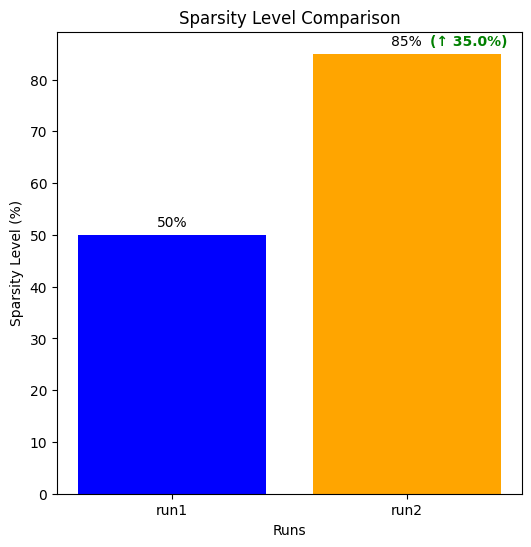

In [56]:
# First plot: Sparsity level comparison
sparsity_values = [sparsity_levels[run] for run in runs]  # Convert to percentages

plt.figure(figsize=(6, 6))
bars = plt.bar(runs, sparsity_values, color=[colors[run] for run in runs])
plt.xlabel('Runs')
plt.ylabel('Sparsity Level (%)')
plt.title('Sparsity Level Comparison')

# Adding value labels and percentage change for run2
for idx, (bar, value) in enumerate(zip(bars, sparsity_values)):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    # Value label
    plt.text(x, y + 1, f'{value:.0f}%', ha='center', va='bottom')
    
    # For run2, add percentage change compared to run1
    if runs[idx] == 'run2':
        sparsity_run1 = sparsity_levels['run1']
        sparsity_run2 = sparsity_levels['run2']
        if sparsity_run1 != 0:
            percentage_change_sparsity = (sparsity_run2 - sparsity_run1)
        else:
            percentage_change_sparsity = 0  # Avoid division by zero

        # Determine arrow and color
        if percentage_change_sparsity > 0:
            arrow = '↑'
            color = 'green'  # Increase is positive for sparsity
        elif percentage_change_sparsity < 0:
            arrow = '↓'
            color = 'red'    # Decrease is negative for sparsity
        else:
            arrow = ''
            color = 'black'

        # Format percentage change
        percentage_change_text = f"({arrow} {abs(percentage_change_sparsity):.1f}%)"
        # Place the percentage change text next to the value label
        plt.text(x + 0.1, y + 1, percentage_change_text,
                 ha='left', va='bottom', color=color, fontweight='bold')

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'sparsity_level_comparison.png'), bbox_inches='tight')

plt.show()


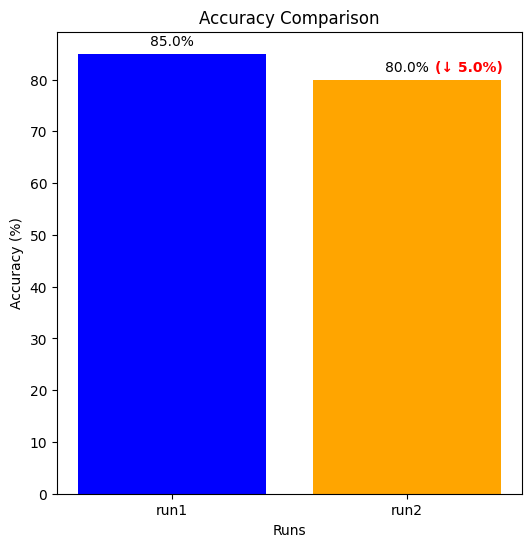

In [59]:
# Second plot: Accuracy comparison
accuracy_values = [accuracies[run] for run in runs]

plt.figure(figsize=(6, 6))
bars = plt.bar(runs, accuracy_values, color=[colors[run] for run in runs])
plt.xlabel('Runs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')

# Adding value labels and percentage change for run2
for idx, (bar, value) in enumerate(zip(bars, accuracy_values)):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    # Value label
    plt.text(x, y + 1, f'{value:.1f}%', ha='center', va='bottom')

    # For run2, add percentage change compared to run1
    if runs[idx] == 'run2':
        accuracy_run1 = accuracies['run1']
        accuracy_run2 = accuracies['run2']
        if accuracy_run1 != 0:
            percentage_change_accuracy = (accuracy_run2 - accuracy_run1)
        else:
            percentage_change_accuracy = 0  # Avoid division by zero

        # Determine arrow and color
        if percentage_change_accuracy > 0:
            arrow = '↑'
            color = 'green'  # Increase is positive for accuracy
        elif percentage_change_accuracy < 0:
            arrow = '↓'
            color = 'red'    # Decrease is negative for accuracy
        else:
            arrow = ''
            color = 'black'

        # Format percentage change
        percentage_change_text = f"({arrow} {abs(percentage_change_accuracy):.1f}%)"
        # Place the percentage change text next to the value label
        plt.text(x + 0.12, y + 1, percentage_change_text,
                 ha='left', va='bottom', color=color, fontweight='bold')

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'accuracy_comparison.png'), bbox_inches='tight')

plt.show()


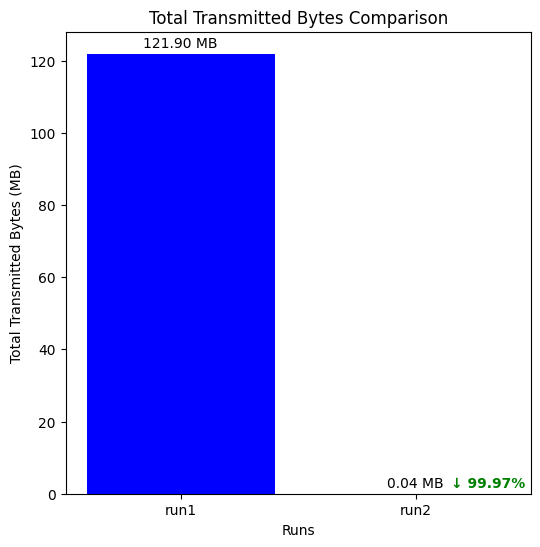

In [62]:
# Third plot: Total transmitted bytes comparison
total_bytes = {}
for run in runs:
    df = dataframes[run]
    total_bytes[run] = df.loc[(df['type'] == 'send') & (df['bytes_tx'].notnull()), 'bytes_tx'].sum()

total_bytes_values = [total_bytes[run] for run in runs]
# Convert bytes to Megabytes (MB)
total_bytes_mb = [value / 1e6 for value in total_bytes_values]

plt.figure(figsize=(6, 6))
bars = plt.bar(runs, total_bytes_mb, color=[colors[run] for run in runs])
plt.xlabel('Runs')
plt.ylabel('Total Transmitted Bytes (MB)')
plt.title('Total Transmitted Bytes Comparison')

# Adding value labels and percentage change for run2
for idx, (bar, value) in enumerate(zip(bars, total_bytes_mb)):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    # Value label
    plt.text(x, y + 1, f'{value:.2f} MB', ha='center', va='bottom')

    # For run2, add percentage change compared to run1
    if runs[idx] == 'run2':
        total_bytes_run1 = total_bytes['run1']
        total_bytes_run2 = total_bytes['run2']
        if total_bytes_run1 != 0:
            percentage_change_bytes = ((total_bytes_run2 - total_bytes_run1) / total_bytes_run1) * 100
        else:
            percentage_change_bytes = 0  # Avoid division by zero

        # Since lower total bytes is better, invert logic
        if percentage_change_bytes < 0:
            arrow = '↓'
            color = 'green'  # Decrease is positive for total transmitted bytes
        elif percentage_change_bytes > 0:
            arrow = '↑'
            color = 'red'    # Increase is negative for total transmitted bytes
        else:
            arrow = ''
            color = 'black'

        # Format percentage change
        percentage_change_text = f"{arrow} {abs(percentage_change_bytes):.2f}%"
        # Place the percentage change text next to the value label
        plt.text(x + 0.15, y + 1, percentage_change_text,
                 ha='left', va='bottom', color=color, fontweight='bold')

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'total_transmitted_bytes_comparison.png'), bbox_inches='tight')

plt.show()


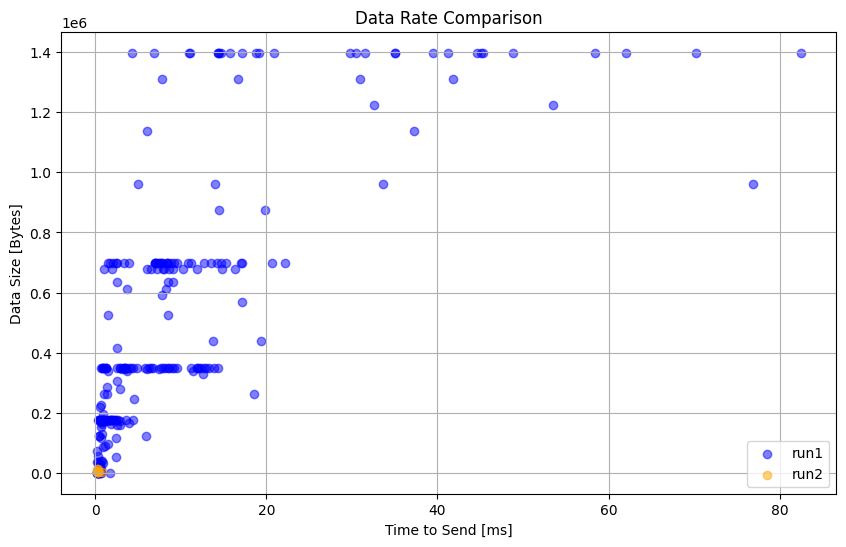

In [44]:
# Fourth plot: Scatterplot of transmitted sizes vs time to send
plt.figure(figsize=(10, 6))
for run in runs:
    df = dataframes[run]
    df_send = df[(df['type'] == 'send') & df['bytes_tx'].notnull()]
    plt.scatter(df_send['dur'], df_send['bytes_tx'], color=colors[run], alpha=0.5, label=run)

plt.xlabel('Time to Send [ms]')
plt.ylabel('Data Size [Bytes]')
plt.title('Data Rate Comparison')
plt.legend()
plt.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'data_rate_comparison.png'), bbox_inches='tight')

plt.show()


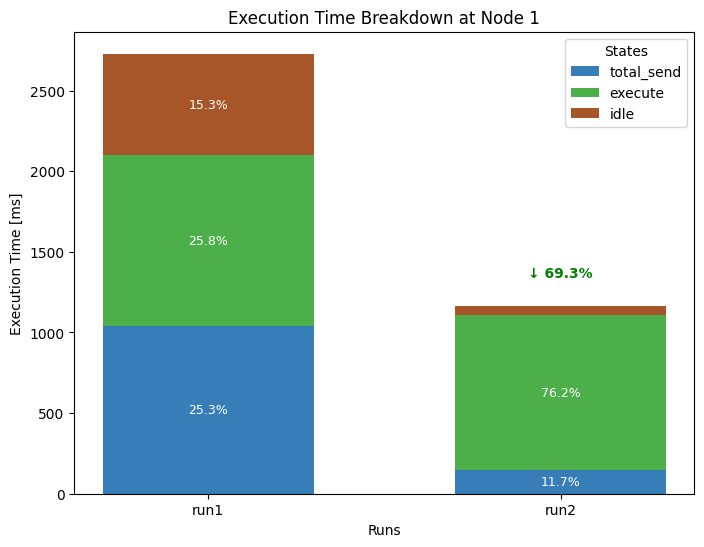

In [65]:
# Node to analyze
node = 1

# Collect execution times for each state and run
execution_times = {}
for run in runs:
    df = dataframes[run]
    df_node = df[df['node'] == node]
    total_time = df_node['dur'].sum()
    state_times = {}
    for state in state_types:
        state_time = df_node.loc[df_node['type'] == state, 'dur'].sum()
        state_times[state] = state_time
    execution_times[run] = {'total_time': total_time, 'state_times': state_times}

# Prepare data for plotting
bar_width = 0.6
x = np.arange(len(runs))  # positions for the bars

fig, ax = plt.subplots(figsize=(8, 6))

bottoms = np.zeros(len(runs))
for state in state_types:
    state_values = [execution_times[run]['state_times'][state] for run in runs]
    bars = ax.bar(x, state_values, bottom=bottoms, width=bar_width, color=state_colors[state], label=state)
    # Calculate percentages for labeling
    for idx, bar in enumerate(bars):
        total_time = execution_times[runs[idx]]['total_time']
        percent = (state_values[idx] / total_time) * 100 if total_time > 0 else 0
        if percent > 5:  # Only label segments larger than 5% to avoid clutter
            ax.text(bar.get_x() + bar.get_width()/2, bottoms[idx] + state_values[idx]/2,
                    f'{percent:.1f}%', ha='center', va='center', color='white', fontsize=9)
    bottoms += state_values

ax.set_xticks(x)
ax.set_xticklabels(runs)
ax.set_xlabel('Runs')
ax.set_ylabel('Execution Time [ms]')
ax.set_title(f'Execution Time Breakdown at Node {node}')
ax.legend(title='States')

# Calculate percentage reduction for run2 compared to run1
total_time_run1 = execution_times['run1']['total_time']
total_time_run2 = execution_times['run2']['total_time']
if total_time_run1 != 0:
    percentage_change_time = ((total_time_run2 - total_time_run1) / total_time_run1) * 100
else:
    percentage_change_time = 0  # Avoid division by zero

# Determine arrow and color
if percentage_change_time < 0:
    arrow = '↓'
    color = 'green'  # Decrease is positive for execution time reduction
elif percentage_change_time > 0:
    arrow = '↑'
    color = 'red'    # Increase is negative for execution time
else:
    arrow = ''
    color = 'black'

# Format percentage change
percentage_change_text = f"{arrow} {abs(percentage_change_time):.1f}%"

# Add the text on top of the second bar
x_pos = x[1]  # Position of the second bar
y_pos = execution_times['run2']['total_time'] + max(execution_times['run2']['total_time'] * 0.05, 10)
ax.text(x_pos, y_pos, percentage_change_text, ha='center', va='bottom', color=color, fontweight='bold')

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'execution_time_breakdown_node1.png'), bbox_inches='tight')

plt.show()
